In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

os.chdir(os.path.dirname('../'))
from algorithm import test_env

Auxiliary Functions

In [2]:
def load_weights(path_to_weights):
    # actor parameters
    actor_weights = {}
    for file in os.listdir(path_to_weights):
        if 'actor' in file:
            param_name = file.replace('actor_', '').replace('.txt', '')
            actor_weights[param_name] = np.loadtxt(os.path.join(path_to_weights, file))
    
    W_actor = actor_weights['simple_fc1.weight']
    b_actor = actor_weights['simple_fc1.bias']
    
    # critic parameters
    critic_weights = {}
    for file in os.listdir(path_to_weights):
        if 'critic' in file:
            param_name = file.replace('critic_', '').replace('.txt', '')
            critic_weights[param_name] = np.loadtxt(os.path.join(path_to_weights, file))
    
    W_critic = critic_weights['simple_fc1.weight']
    b_critic = critic_weights['simple_fc1.bias']

    return {'W_actor': W_actor,
            'b_actor': b_actor,
            'W_critic': W_critic,
            'b_critic': b_critic}

In [3]:
def log_alpha(π, α=1):
    if α == 1:
        return torch.log(π)
    else:
        return (torch.pow(π, α-1)-1)/(α * (α-1))

def Tsallis_Entropy(π, α=1):
        return - π * log_alpha(π, α)

Actor and Critic classes

In [4]:
class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        return F.softmax(x, dim=0)

class Critic(nn.Module):
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        return self.fc1(x)

In [5]:
path_to_weights = 'weights'
weights = load_weights(path_to_weights) # we have to copy when passing as constructor, because of inplace operations!

# Global Variables

In [20]:
# Global Variables

γ = 0.99 # discount factor
α = 1
λ = 1

lr = 1e-3 # learning rate
n_iterations = 10000

print_grads = False

In [21]:
auto_grad_ploss = list()
anal_grad_ploss = list()

# Numerical Results

In [22]:
n_actions = len(weights['b_actor'])

# Initialize the networks
actor  = Actor(n_actions, n_actions)
critic = Critic(n_actions, n_actions)

# Set the weights for the actor
actor.fc1.weight.data = torch.from_numpy(weights['W_actor'].copy())
actor.fc1.bias.data = torch.from_numpy(weights['b_actor'].copy())

# Set the weights for the critic
critic.fc1.weight.data = torch.from_numpy(weights['W_critic'].copy())
critic.fc1.bias.data = torch.from_numpy(weights['b_critic'].copy())

# Define the optimizers
actor_optimizer = torch.optim.SGD(actor.parameters(), lr=lr)
critic_optimizer = torch.optim.SGD(critic.parameters(), lr=lr)

In [23]:
env = test_env(n_actions)

# initialize environment
state = env.reset()

# store p_loss values
auto_grad_ploss = list()

for _ in range(n_iterations):
    # Environment step
    policy = actor(torch.tensor(state))
    action = torch.argmax(policy.detach(), dim=0)
    
    next_state, reward, _, _ = env.step(action)
    
    # Gradient step
    
    # Critic
    with torch.no_grad():
        next_qvals  = critic.forward(torch.tensor(next_state)) 
        next_policy = actor.forward(torch.tensor(next_state))
        next_action = torch.argmax(next_policy, dim=0)
    
        target = reward + γ * (next_qvals[next_action] - (λ/α) * log_alpha(next_policy[next_action]))
    
    qvals  = critic.forward(torch.tensor(state))
    v_loss = F.mse_loss(qvals[action], target)/2
    
    # Actor
    linear_term  = policy * qvals.detach()
    entropy_term = Tsallis_Entropy(policy, α) # Shannon Entropy
    
    p_loss = -torch.sum(linear_term + entropy_term)

    auto_grad_ploss.append(p_loss.item())
    
    # Reset the gradients
    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()
    
    # backward pass
    v_loss.backward()
    p_loss.backward()

    if print_grads == True:
        print("-- Actor --\n")
        print("Actor weights' gradient:\n")
        print(actor.fc1.weight.grad.numpy())
        
        print('\n')
        
        print("Actor bias' gradient:\n")
        print(actor.fc1.bias.grad.numpy())

        print("\n\n-- Critic --\n")
        print("Critic weights' gradient:\n")
        print(critic.fc1.weight.grad.numpy())
        
        print('\n')
        
        print("Critic bias' gradient:\n")
        print(critic.fc1.bias.grad.numpy())
    
    # Update the weights
    actor_optimizer.step()
    critic_optimizer.step()

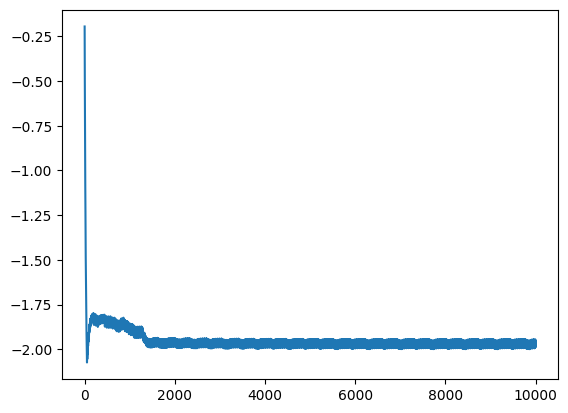

In [24]:
plt.plot(auto_grad_ploss)

# Analytical Results

In [11]:
class AActor():
    def __init__(self, weights, bias):
        self.W = torch.tensor(weights, requires_grad=False)
        self.b = torch.tensor(bias, requires_grad=False)
        
    def forward(self, state):
        return torch.nn.functional.softmax(self.W @ state + self.b, dim=0)

class ACritic():
    def __init__(self, weights, bias):
        self.W = torch.tensor(weights, requires_grad=False)
        self.b = torch.tensor(bias, requires_grad=False)
        
    def forward(self, state):
        return self.W @ state + self.b

In [12]:
n_actions = len(weights['b_actor'])

aactor  = AActor(weights['W_actor'], weights['b_actor'])
acritic = ACritic(weights['W_critic'], weights['b_critic'])

In [13]:
env = test_env(n_actions)

# initialize environment
state = env.reset()

# store p_loss values
anal_grad_ploss = list()

for _ in range(n_iterations):
    # -- Environment step --
    policy = aactor.forward(torch.tensor(state))
    action = torch.argmax(policy.detach(), dim=0)
    
    next_state, reward, _, _ = env.step(action)
    
    # -- Gradient step --
    
    # Critic
    next_qvals  = acritic.forward(torch.tensor(next_state)) 
    next_policy = aactor.forward(torch.tensor(next_state))
    next_action = torch.argmax(next_policy, dim=0)
    
    target = reward + γ * (next_qvals[next_action] - (λ/α) * log_alpha(next_policy[next_action]))
    
    qvals  = acritic.forward(torch.tensor(state))

    # gradient \nabla_{\theta}Q_{\theta}
    # one-hot matrix
    one_hot_matrix = np.zeros((n_actions, n_actions))
    one_hot_matrix[action, :] = np.ones(n_actions)
    
    one_hot_vector = np.zeros(n_actions)
    one_hot_vector[action] = 1
    
    # element-wise multiplication
    delw_C = (one_hot_matrix) * (qvals[action].numpy() - target.numpy()) * np.array([state for i in range(n_actions)])
    delb_C = (one_hot_vector) * (qvals[action].numpy() - target.numpy()) * np.ones(n_actions)
    
    # Actor
    linear_term  = policy * qvals.detach()
    entropy_term = Tsallis_Entropy(policy, α) # Shannon Entropy
    
    p_loss = -torch.sum(linear_term + entropy_term)
    anal_grad_ploss.append(p_loss.item())

    grad_soft = np.diag(policy) - np.outer(policy, policy)
    delw_A = -(qvals.numpy() - np.log(policy).numpy() - 1) * grad_soft @ np.array([state for i in range(n_actions)])
    delb_A = -(qvals.numpy() - np.log(policy).numpy() - 1) * grad_soft @ np.ones(n_actions)

    
    # Gradient descent
    aactor.W -= torch.tensor(lr * delw_A)
    aactor.b -= torch.tensor(lr * delb_A)

    acritic.W -= torch.tensor(lr * delw_C)
    acritic.b -= torch.tensor(lr * delb_C)

    if print_grads == True:
        print("-- Actor --\n")
        print("Actor weights' gradient:\n")
        print(delw_A)
        
        print('\n')
        
        print("Actor bias' gradient:\n")
        print(delb_A)

        print("-- Critic --\n")
        print("Critic weights' gradient:\n")
        print(delw_C)
        
        print('\n')
        
        print("Critic bias' gradient:\n")
        print(delb_C)

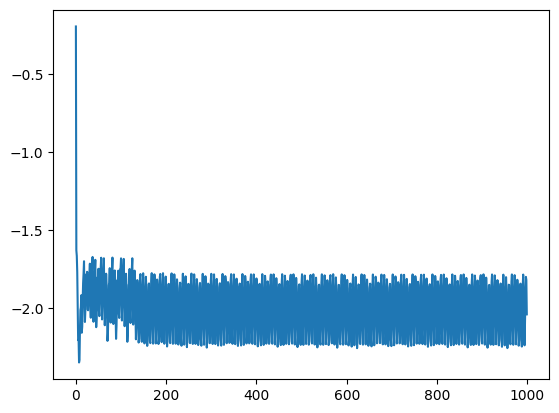

In [14]:
plt.plot(anal_grad_ploss)

# Comparing both methods

In [15]:
dist = np.array(anal_grad_ploss) - np.array(anal_grad_ploss)
print(dist.mean())
print(dist.std())

0.0
0.0
